<a href="https://colab.research.google.com/github/haya-salami/fmri_analysis_and_preprocessing/blob/main/plot_seed_to_voxel_correlation_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#**Introduction to Neuroimaging anlaysis with Nilearn**



###1.   Upload an image, plotting, simple arithmatics
###2.   Seed based correlations

### other examples can be found [here](https://osf.io/ys5ac) and [here](https://carpentries-incubator.github.io/SDC-BIDS-fMRI/03-basic_image_manipulation/index.html)




###[Nilearn](https://nilearn.github.io/stable/index.html)


#### Setup and imports:

In [17]:
!pip install nilearn
%matplotlib inline
import os
import matplotlib.pyplot as plt  
from nilearn import image as nimg         
from nilearn import plotting as nplot
import numpy as np

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/



##Basic nilearn example: manipulating and looking at data

A simple example showing how to load an existing Nifti file and use basic nilearn functionalities.


In [18]:
# We will use a Nifti file 
t1_img_path= f'/content/sub-Y02_desc-preproc_T1w.nii.gz'

# Note that the variable img_path is just a path to a Nifti file
print(f'Path to MNI152 template:{t1_img_path}')

Path to MNI152 template:/content/sub-Y02_desc-preproc_T1w.nii.gz


##### Let's make sure the dimensions are ok




In [19]:
t1_img = nimg.load_img(t1_img_path)
print(f"dimensions of t1_img: {t1_img.shape}")

dimensions of t1_img: (176, 240, 256)


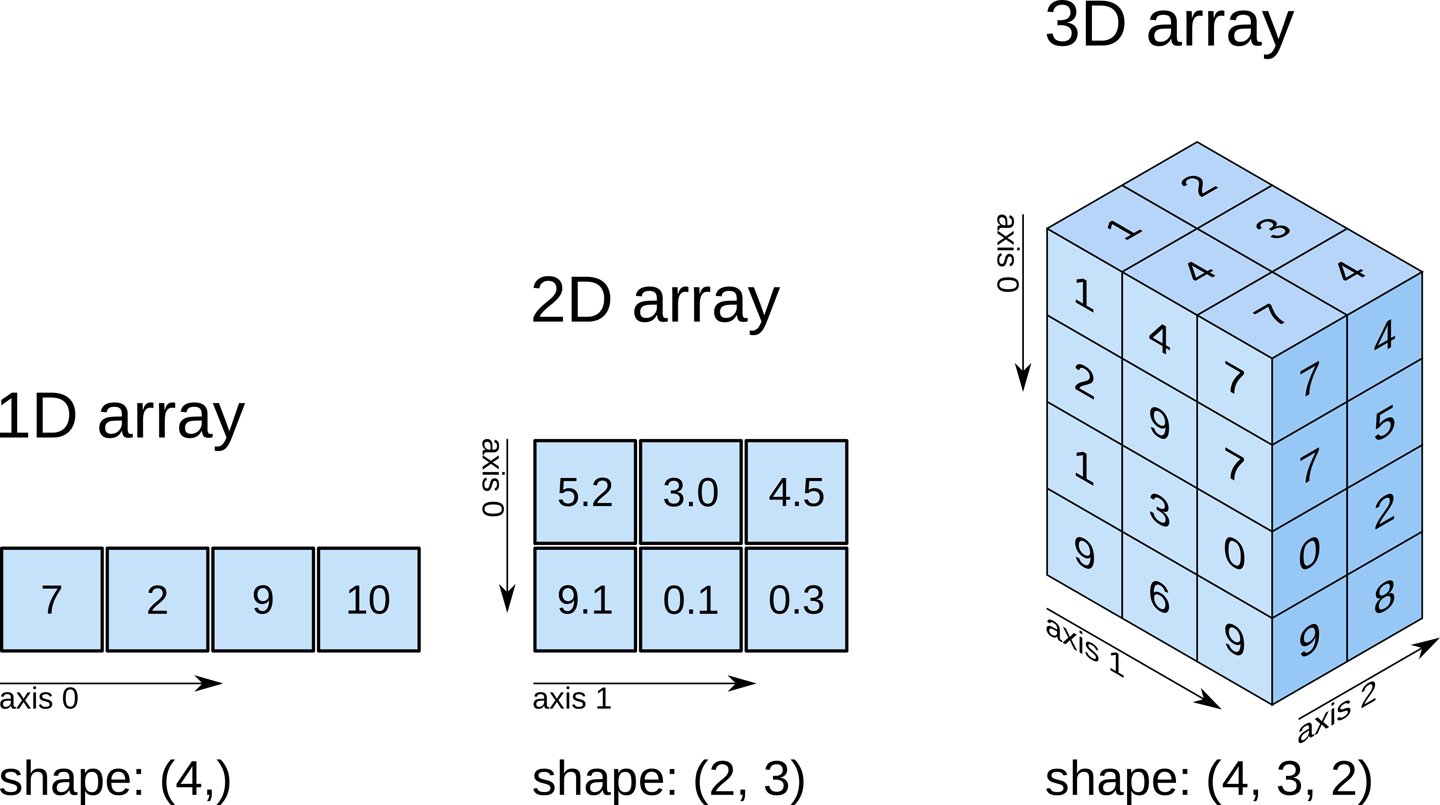

Image [Link](https://https://carpentries-incubator.github.io/SDC-BIDS-fMRI/03-basic_image_manipulation/index.html)

A quick plot


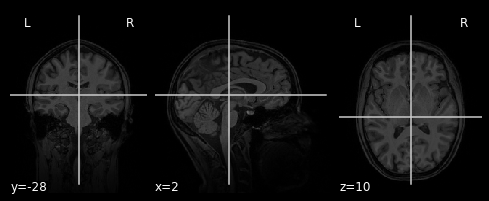

In [20]:
nplot.plot_anat(t1_img)   

#### Plot an interactive view



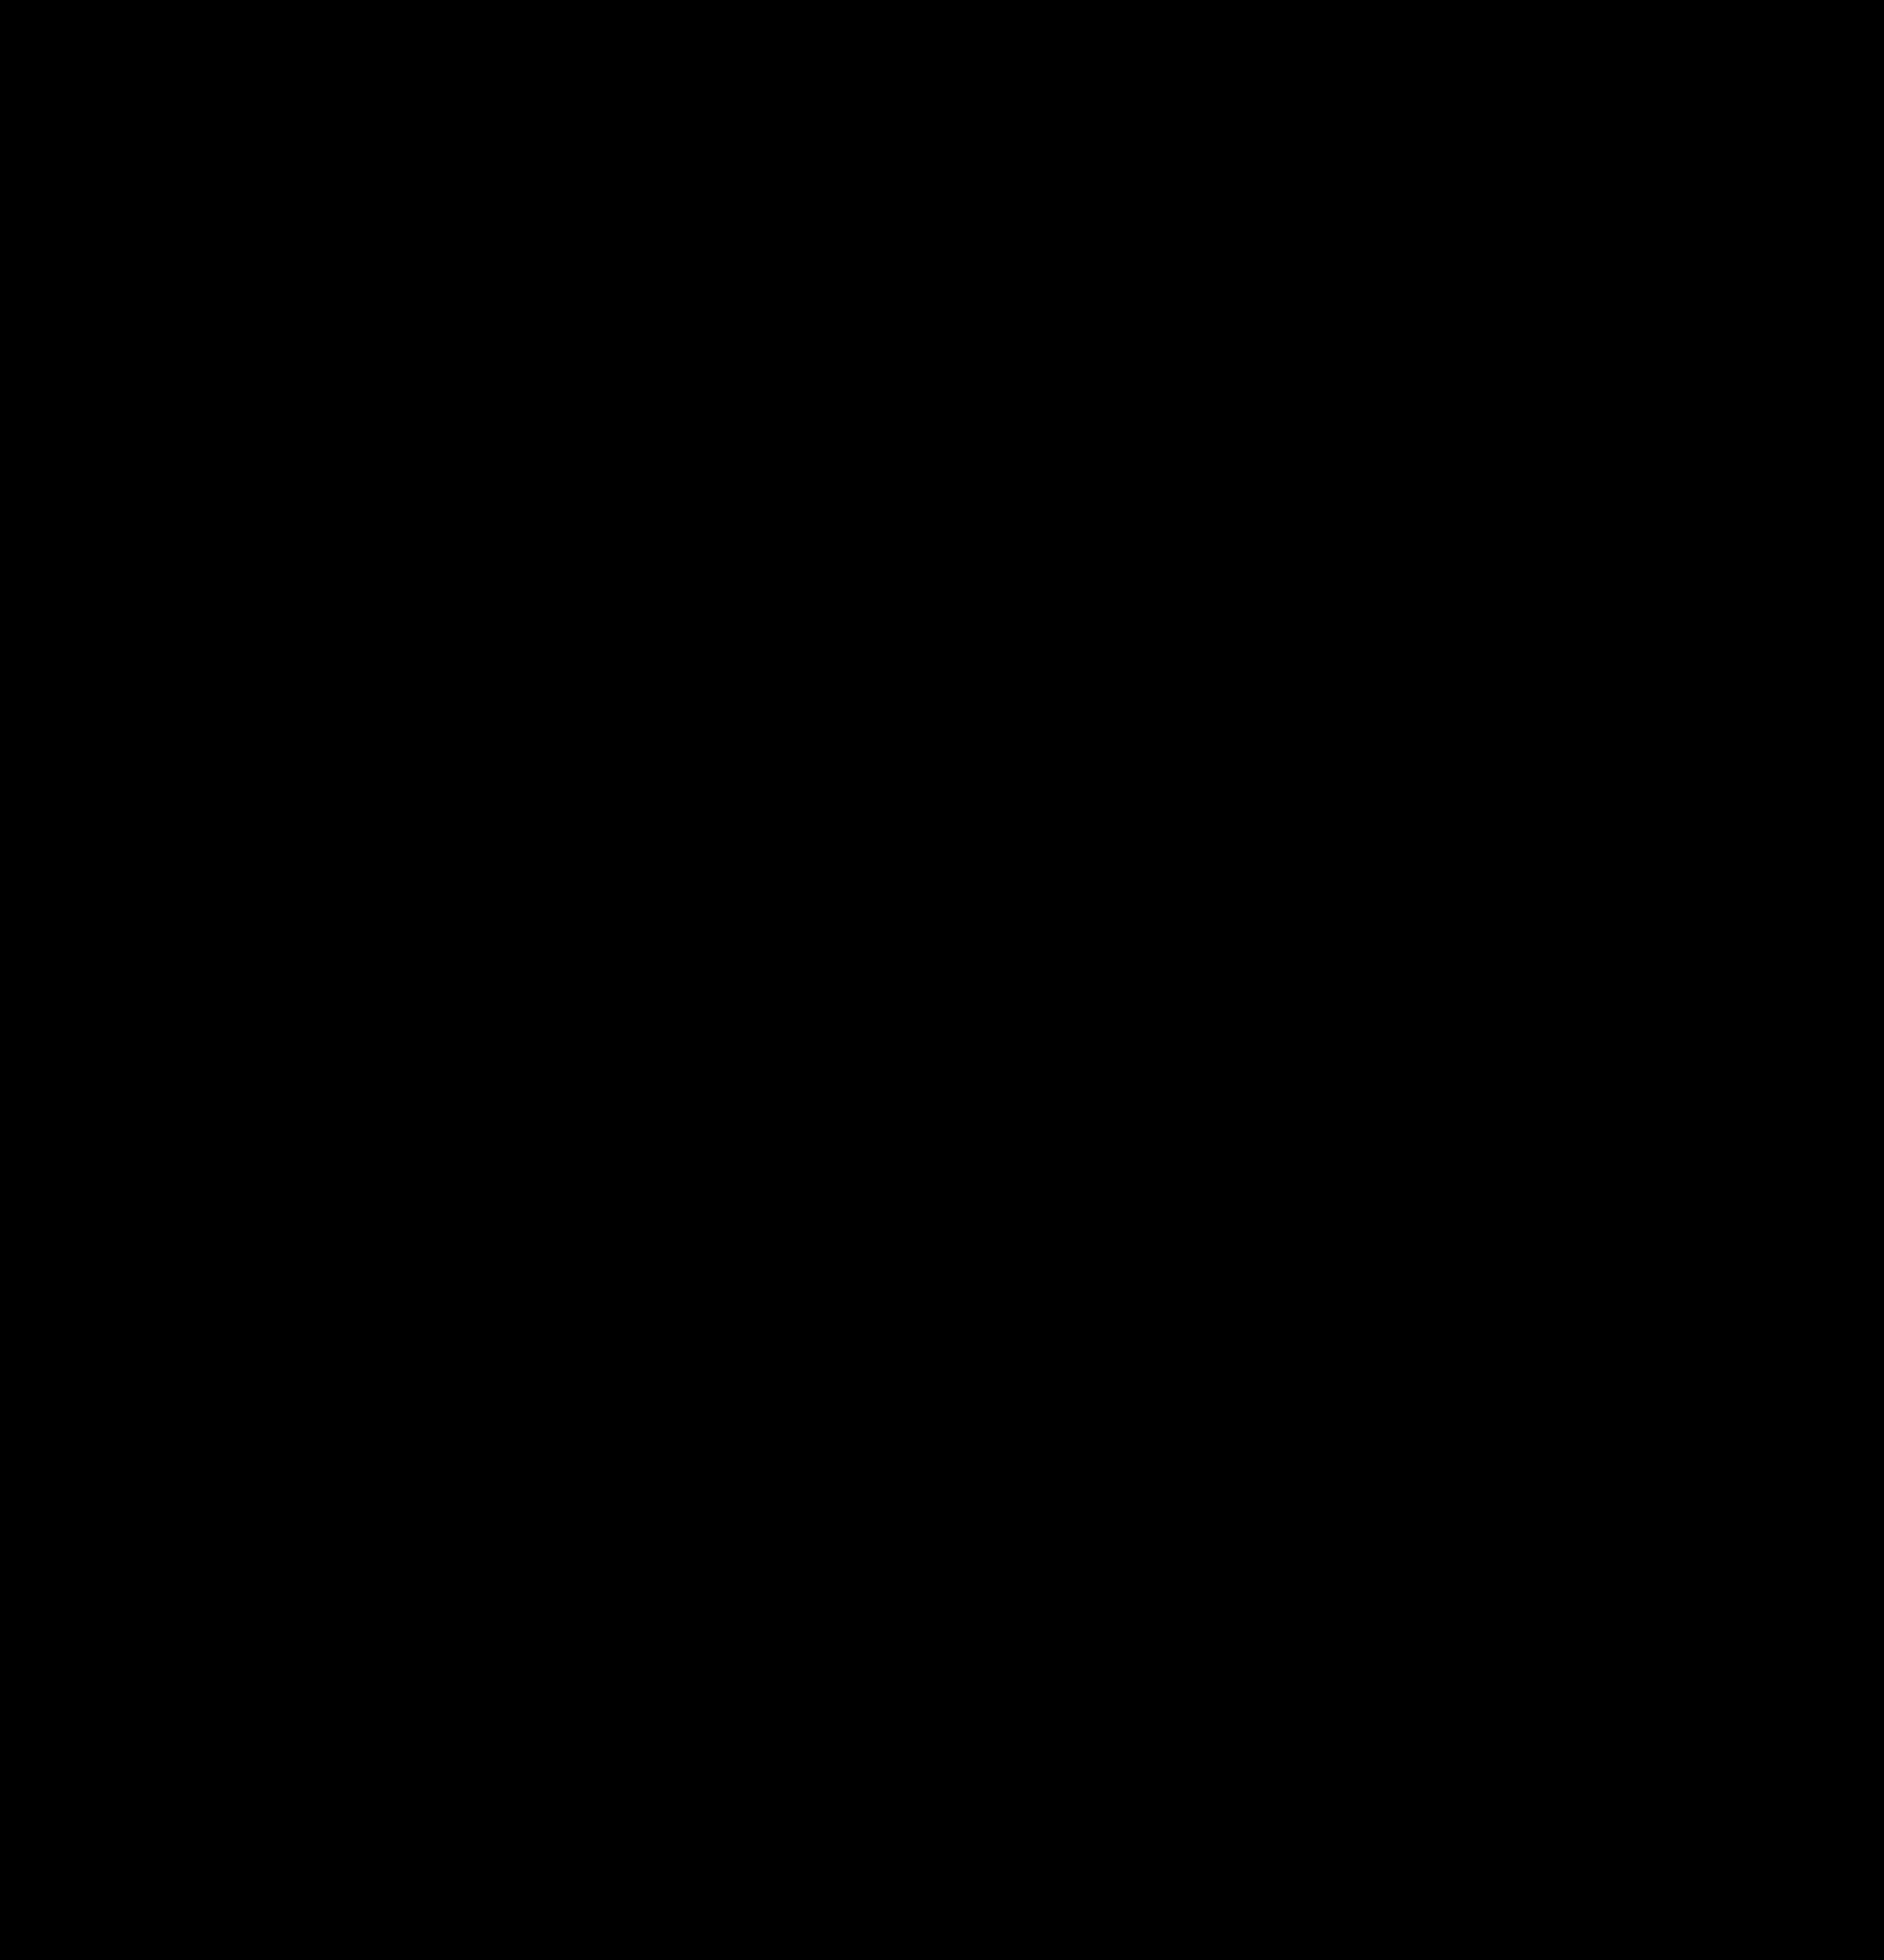
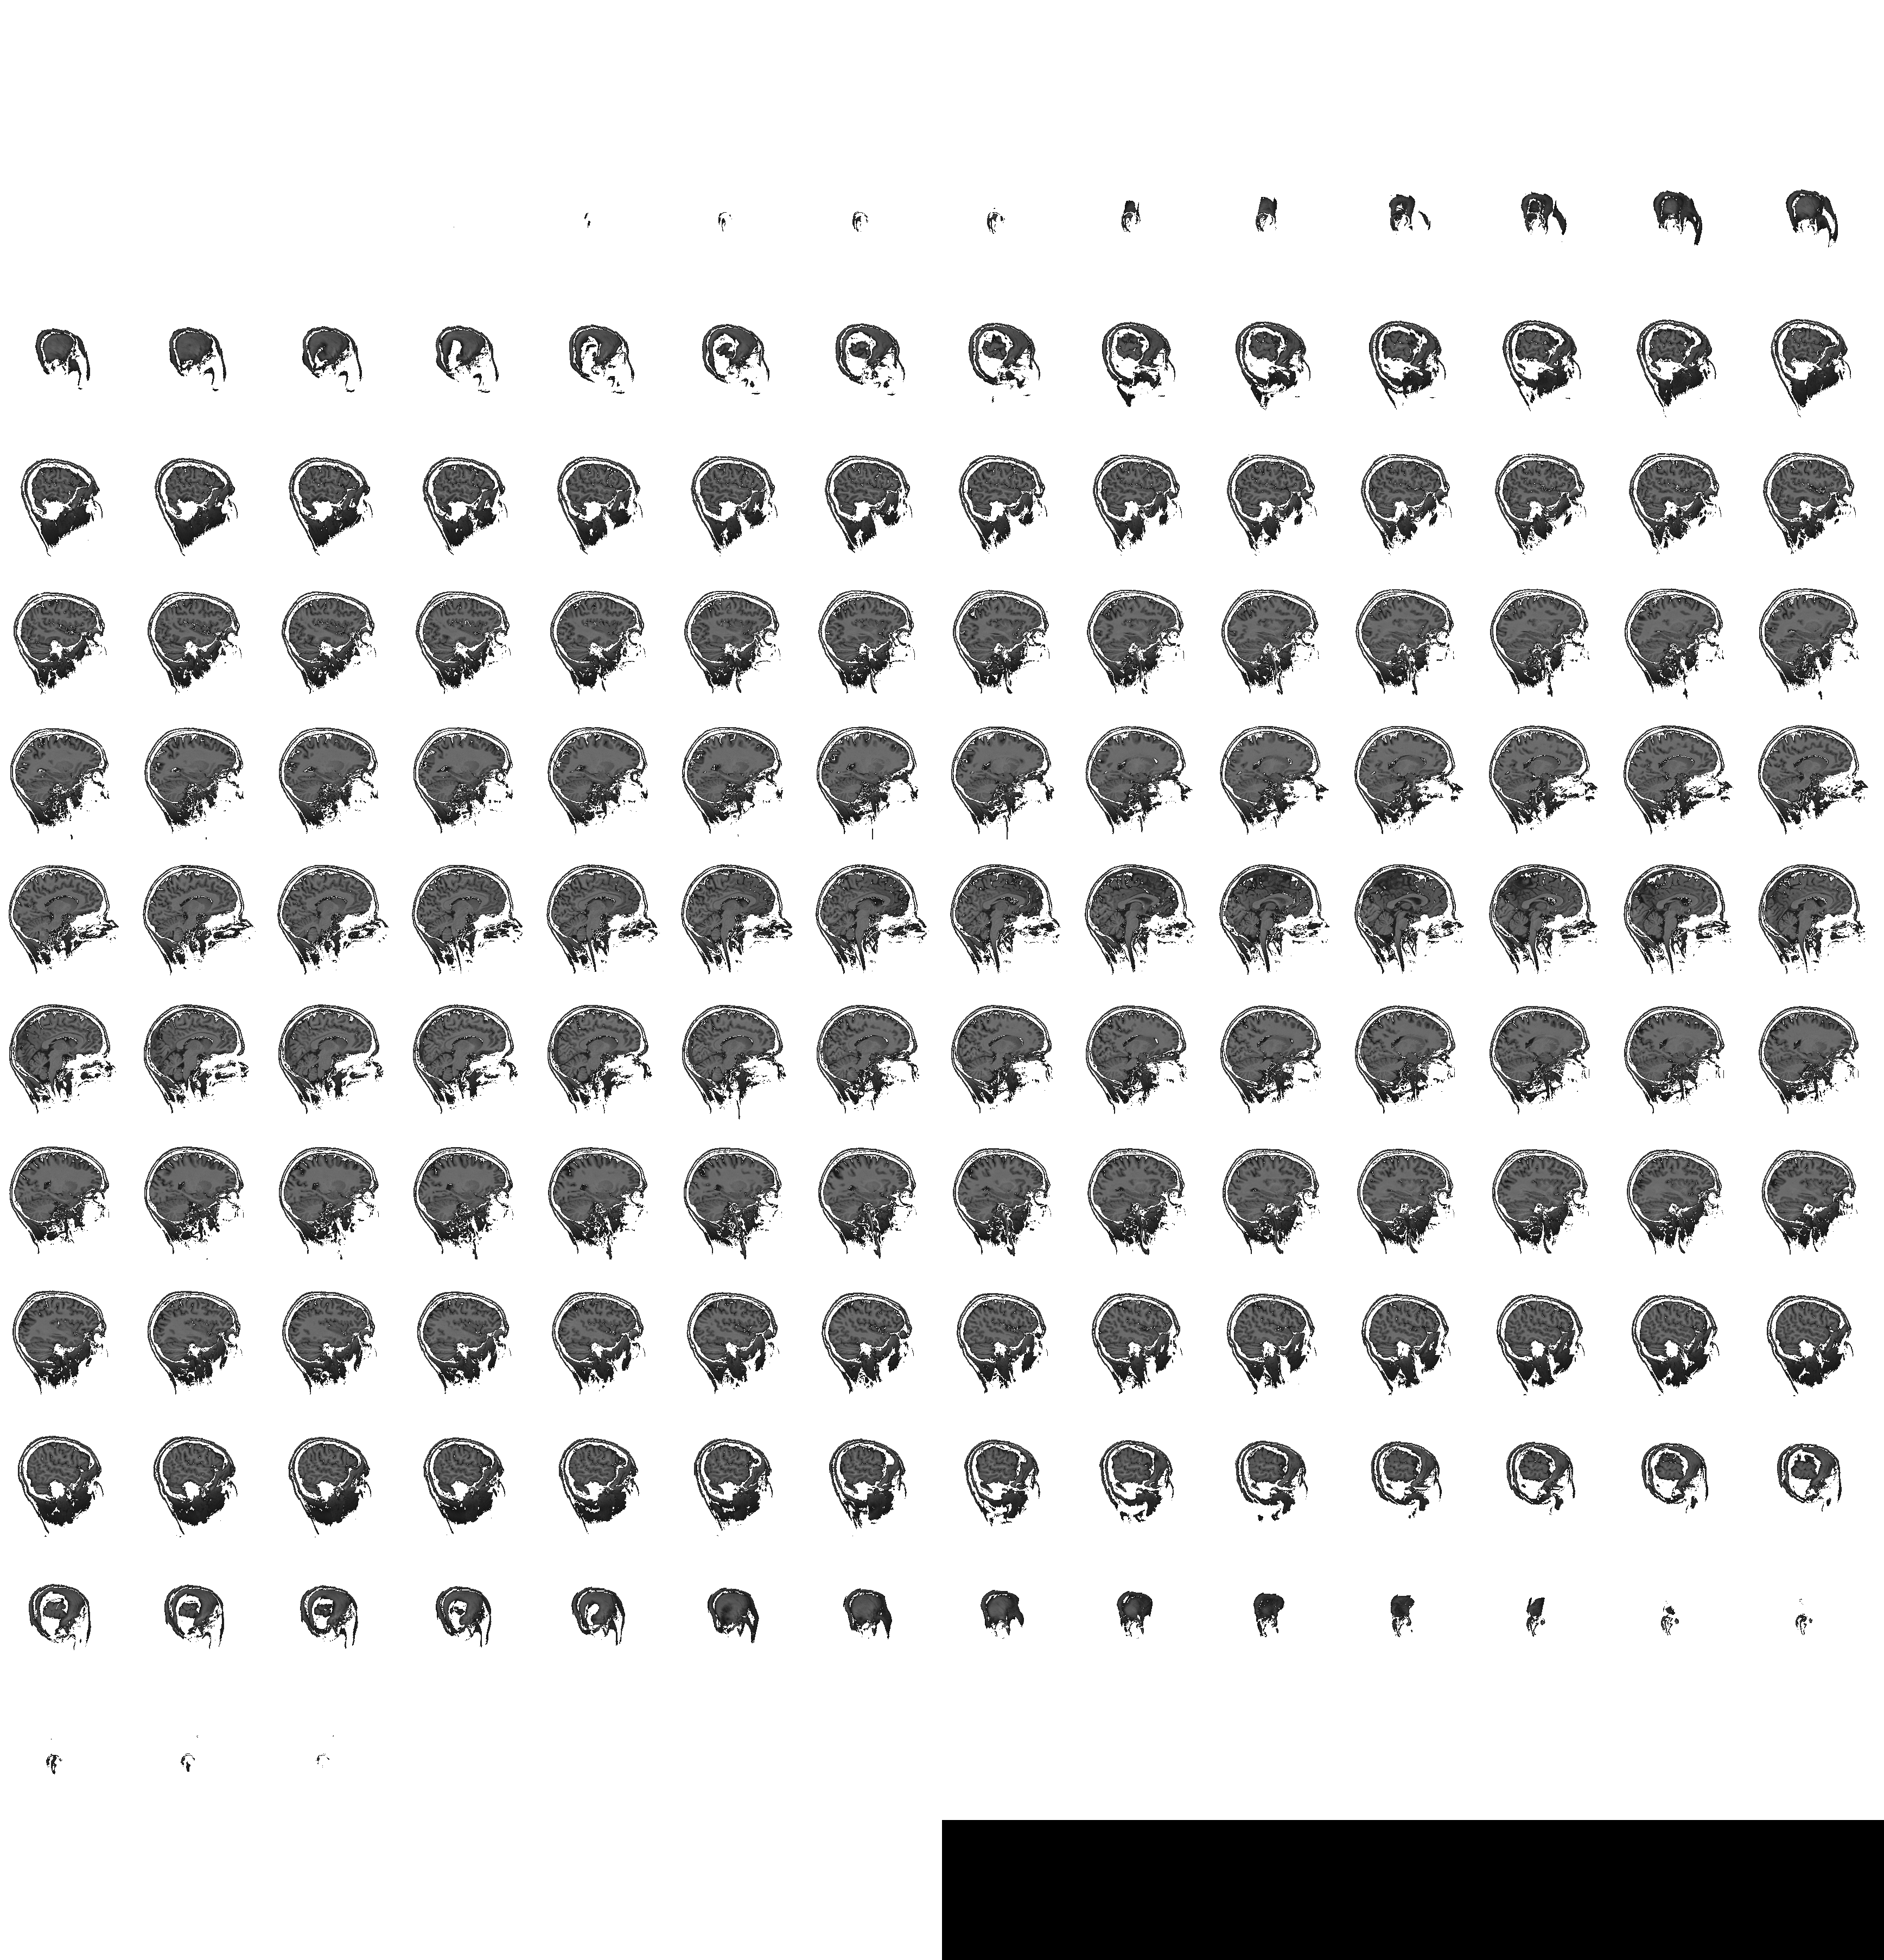

In [21]:
nplot.view_img(t1_img, 
               bg_img=False, # Disable using a standard image as the background
               cmap='Greys_r', # Set color scale so white matter appears lighter than grey
               symmetric_cmap=False, # We don't have negative values
               threshold="auto", # Clears out the background
)

#### Nilearn has many plotting options [Plots Nilearn](https://nilearn.github.io/stable/plotting/index.html)

### Simple Arithmetic Operations

Let’s start performing some image operations. The simplest operations we can perform is element-wise, what this means is that we want to perform some sort of mathematical operation on each voxel of the MR image. 
Since voxels are represented in a 3D array, this is equivalent to performing an operation on each element (i,j,k) of a 3D array. 



Let’s try inverting the image, that is, flip the colour scale such that all blacks appear white and vice-versa. To do this, we’ll use the method


```
nimg.math_img(formula, **imgs) Where:
```

formula is a mathematical expression such as 'a+1'
 
 **imgs is a set of key-value pairs linking variable names to images. For example a=T1

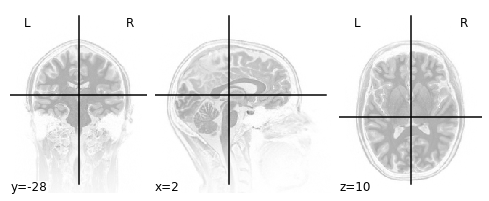

In [22]:
invert_img = nimg.math_img('-a', a=t1_img)
nplot.plot_anat(invert_img)

### Let's apply a mask

##### Load mask image:

In [23]:
bm_path = f"/content/sub-Y02_desc-brain_mask.nii.gz"

bm_img = nimg.load_img(bm_path)

print(f"dimensions of bm_img: {bm_img.shape}")

dimensions of bm_img: (176, 240, 256)


##### Apply the mask as multiplication (and) img*mask 



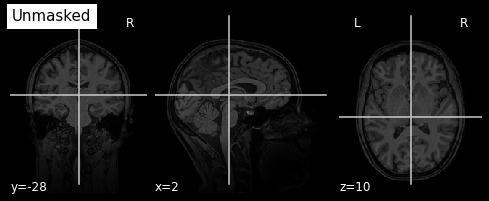

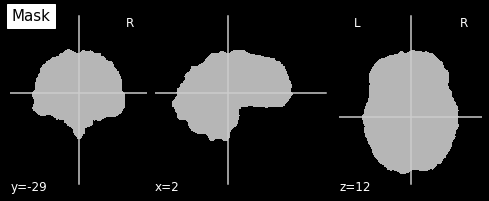

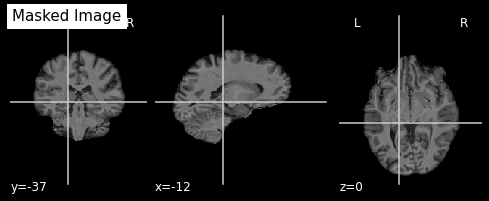

In [24]:
masked_t1 = nimg.math_img('a*b', a=t1_img, b=bm_img)

#Visualise images

nplot.plot_anat(t1_img, title = "Unmasked") 

nplot.plot_anat(bm_img, title = "Mask")

nplot.plot_anat(masked_t1, title = "Masked Image")

### Smoothing
#### Let's use an image-smoothing function from 

Functions containing 'img' can take either a filename or an image as input.

Here we give as inputs the image and the smoothing value in mm

```
# nilearn: :func:nilearn.image.smooth_img
```



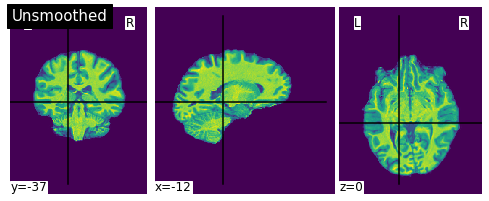

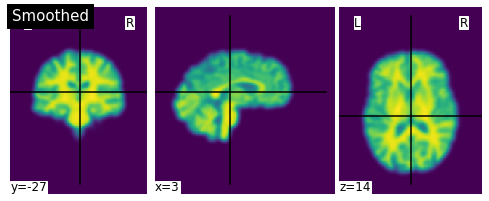

In [43]:
masked_t1_smoothed = nimg.smooth_img(masked_t1, fwhm=6)

nplot.plot_img(masked_t1, title = "Unsmoothed")

nplot.plot_img(masked_t1_smoothed, title = "Smoothed")

#### More smoothing

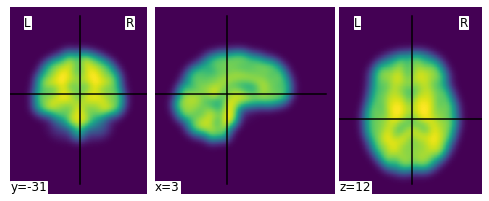

In [26]:
masked_t1_smoothed2 = nimg.smooth_img(masked_t1, fwhm=15)

nplot.plot_img(masked_t1_smoothed2)


##Producing single subject maps of seed-to-voxel correlation

This example shows how to produce seed-to-:term:`voxel` correlation maps
for a single subject based on movie-watching :term:`fMRI` scans.
These maps depict the temporal correlation of a **seed region** with the
**rest of the brain**.

This example is an advanced one that requires manipulating the data with numpy.
Note the difference between images, that lie in brain space, and the
numpy array, corresponding to the data inside the mask.

See also `for a similar example using cortical surface input data
<sphx_glr_auto_examples_01_plotting_plot_surf_stat_map.py>`.

Author: Franz Liem


### Getting the data

We will work with the first subject of the brain development fmri data set.
dataset.func is a list of filenames. We select the 1st (0-based)
subject by indexing with [0]).



In [27]:
from nilearn import datasets

dataset = datasets.fetch_development_fmri(n_subjects=1)
func_filename = dataset.func[0]
confound_filename = dataset.confounds[0]


Dataset created in /root/nilearn_data/development_fmri


Dataset created in /root/nilearn_data/development_fmri/development_fmri



 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


### Dataset discription [Nilearn](https://nilearn.github.io/dev/modules/generated/nilearn.datasets.fetch_development_fmri.html) [OpenNeuro](https://openneuro.org/datasets/ds000228/versions/1.0.0) 

Note that func_filename and confound_filename are strings pointing to
files on your hard drive.



In [28]:
print(func_filename)
print(confound_filename)

/root/nilearn_data/development_fmri/development_fmri/sub-pixar123_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
/root/nilearn_data/development_fmri/development_fmri/sub-pixar123_task-pixar_desc-reducedConfounds_regressors.tsv


## Time series extraction

We are going to extract signals from the functional time series in two
steps. First we will extract the mean signal within the **seed region of
interest**. Second, we will extract the **brain-wide voxel-wise time series**.

We will be working with one seed sphere in the Posterior Cingulate Cortex
(PCC), considered part of the Default Mode Network.



In [29]:
pcc_coords = [(0, -52, 18)]

#### We can try to extract time serirs at these coods with a slicing function provided by nilearn:

In [30]:
func_img = nimg.load_img(func_filename)
single_vox = func_img.slicer[0:1,-52:-51,18:19,:].get_fdata()
single_vox.shape

(1, 1, 1, 168)

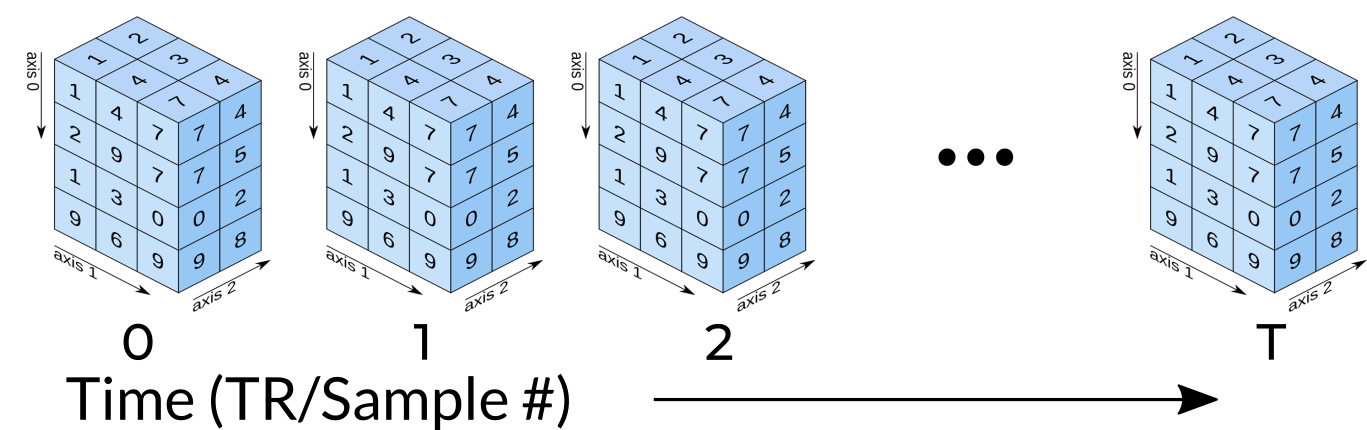

We use :class:`nilearn.maskers.NiftiSpheresMasker` to extract the
**time series from the functional imaging within the sphere**. The
sphere is centered at pcc_coords and will have the radius we pass the
NiftiSpheresMasker function (here 8 mm).

The extraction will also detrend, standardize, and bandpass filter the data.
This will create a NiftiSpheresMasker object.



In [31]:
from nilearn.maskers import NiftiSpheresMasker

seed_masker = NiftiSpheresMasker(
    pcc_coords, radius=8, detrend=True, standardize=True,
    low_pass=0.1, high_pass=0.01, t_r=2,
    memory='nilearn_cache', memory_level=1, verbose=0)

Then we extract the mean time series within the seed region while
regressing out the confounds that
can be found in the dataset's csv file



In [32]:
seed_time_series = seed_masker.fit_transform(func_filename,
                                             confounds=[confound_filename])

Next, we can proceed similarly for the **brain-wide voxel-wise time
series**, using :class:`nilearn.maskers.NiftiMasker` with the same input
arguments as in the seed_masker in addition to smoothing with a 6 mm kernel



In [33]:
from nilearn.maskers import NiftiMasker

brain_masker = NiftiMasker(
    smoothing_fwhm=6, detrend=True, standardize=True,
    low_pass=0.1, high_pass=0.01, t_r=2,
    memory='nilearn_cache', memory_level=1, verbose=0)

Then we extract the brain-wide voxel-wise time series while regressing
out the confounds as before



In [34]:
brain_time_series = brain_masker.fit_transform(func_filename,
                                               confounds=[confound_filename])

### Look at the slide if necessary

We can now inspect the extracted time series. Note that the **seed time
series** is an array with shape n_volumes, 1), while the
**brain time series** is an array with shape (n_volumes, n_voxels).



In [35]:
print("Seed time series shape: (%s, %s)" % seed_time_series.shape)
print("Brain time series shape: (%s, %s)" % brain_time_series.shape)

Seed time series shape: (168, 1)
Brain time series shape: (168, 32504)


We can plot the **seed time series**.



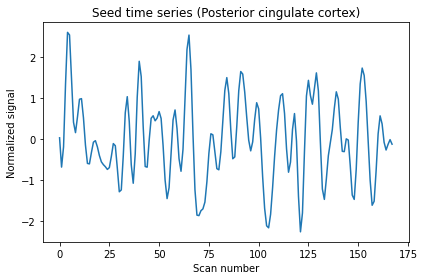

In [36]:
import matplotlib.pyplot as plt

plt.plot(seed_time_series)
plt.title('Seed time series (Posterior cingulate cortex)')
plt.xlabel('Scan number')
plt.ylabel('Normalized signal')
plt.tight_layout()

Exemplarily, we can also select 5 random voxels from the **brain-wide
data** and plot the time series from.



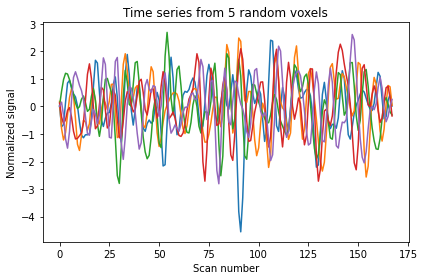

In [37]:
plt.plot(brain_time_series[:, [10, 45, 100, 5000, 10000]])
plt.title('Time series from 5 random voxels')
plt.xlabel('Scan number')
plt.ylabel('Normalized signal')
plt.tight_layout()

## Performing the seed-to-voxel correlation analysis

Now that we have two arrays (**sphere signal**: (n_volumes, 1),
**brain-wide voxel-wise signal** (n_volumes, n_voxels)), we can correlate
the **seed signal** with the **signal of each voxel**. The dot product of
the two arrays will give us this correlation. Note that the signals have
been variance-standardized during extraction. To have them standardized to
norm unit, we further have to divide the result by the length of the time
series.



In [38]:
import numpy as np

seed_to_voxel_correlations = (np.dot(brain_time_series.T, seed_time_series) /
                              seed_time_series.shape[0]
                              )

The resulting array will contain a value representing the correlation
values between the signal in the **seed region** of interest and **each
voxel's signal**, and will be of shape (n_voxels, 1). The correlation
values can potentially range between -1 and 1.



In [39]:
print("Seed-to-voxel correlation shape: (%s, %s)" %
      seed_to_voxel_correlations.shape)
print("Seed-to-voxel correlation: min = %.3f; max = %.3f" % (
    seed_to_voxel_correlations.min(), seed_to_voxel_correlations.max()))

Seed-to-voxel correlation shape: (32504, 1)
Seed-to-voxel correlation: min = -0.646; max = 0.960


## Plotting the seed-to-voxel correlation map
We can now plot the seed-to-voxel correlation map and perform thresholding
to only show values more extreme than +/- 0.5. Before displaying,
we need to create an in memory Nifti image object.
Furthermore, we can display the location of the seed with a sphere and
set the cross to the center of the seed region of interest.



/usr/local/lib/python3.7/dist-packages/nilearn/plotting/img_plotting.py:300: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()


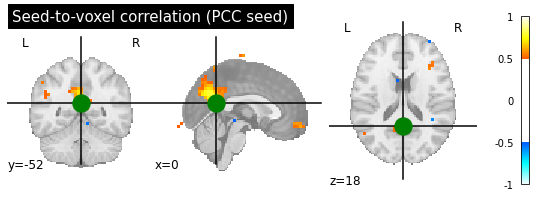

In [40]:
from nilearn import plotting

seed_to_voxel_correlations_img = brain_masker.inverse_transform(
    seed_to_voxel_correlations.T)
display = plotting.plot_stat_map(seed_to_voxel_correlations_img,
                                 threshold=0.5, vmax=1,
                                 cut_coords=pcc_coords[0],
                                 title="Seed-to-voxel correlation (PCC seed)"
                                 )
display.add_markers(marker_coords=pcc_coords, marker_color='g',
                    marker_size=300)
# At last, we save the plot as pdf.
display.savefig('pcc_seed_correlation.pdf')

## Fisher-z transformation and save nifti
Finally, we can Fisher-z transform the data to achieve a normal distribution.
The transformed array can now have values more extreme than +/- 1.



In [41]:
seed_to_voxel_correlations_fisher_z = np.arctanh(seed_to_voxel_correlations)
print("Seed-to-voxel correlation Fisher-z transformed: min = %.3f; max = %.3f"
      % (seed_to_voxel_correlations_fisher_z.min(),
         seed_to_voxel_correlations_fisher_z.max()
         )
      )

Seed-to-voxel correlation Fisher-z transformed: min = -0.768; max = 1.941


Eventually, we can transform the correlation array back to a Nifti image
object, that we can save.



In [42]:
seed_to_voxel_correlations_fisher_z_img = brain_masker.inverse_transform(
    seed_to_voxel_correlations_fisher_z.T)
seed_to_voxel_correlations_fisher_z_img.to_filename(
    'pcc_seed_correlation_z.nii.gz')